# HD 103891

## Import modules

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, leastsq
import scipy.signal as sig

## Load Data

In [4]:
df = pd.read_csv("G:\MSc_Project\Data\hd103891.dat", delimiter='\t')

xData = []
yData=[]
Uncertainty=[]

for row in df[df.columns[0]]:
  xData.append(row)
print(xData)

for row in df[df.columns[1]]:
  yData.append(row)
print(yData)

for row in df[df.columns[2]]:
  Uncertainty.append(row)
print(Uncertainty)


[2453063.80694, 2453789.78139, 2453790.84262, 2453866.60643, 2453868.64102, 2454136.82285, 2454142.83664, 2454234.60119, 2454254.52632, 2454483.7925, 2454487.83046, 2454522.83013, 2454540.77333, 2454541.78467, 2454556.6603, 2454557.65078, 2454558.752, 2454563.66079, 2454582.59476, 2454611.57886, 2454813.85368, 2454850.82788, 2454871.71718, 2454872.80015, 2454921.78824, 2454930.588, 2454931.6658, 2455013.52439, 2455019.4897, 2455019.49746, 2455229.78507, 2455237.81571, 2455247.8219, 2455247.90672, 2455266.77331, 2455293.65302, 2455325.57564, 2455404.47643, 2455588.86816, 2455672.63399, 2455689.56289, 2455695.51915, 2455729.47723, 2455960.88736, 2456023.72922, 2456025.65267, 2456051.70645, 2456080.47594, 2456312.82503, 2456332.84591, 2456356.8728, 2456383.79655, 2456385.71096, 2456411.7368, 2456672.86097, 2456730.75336, 2456731.65786, 2456738.74854, 2456743.61754, 2456763.68259, 2456767.62714, 2456819.6071, 2456863.47332, 2457101.67399, 2457147.64728, 2457157.64768, 2457211.53054, 245721

In [5]:
# Load the time, radial velocity, and jitter data

t = np.array(xData) 
vr = np.array(yData) 
jitter = np.array(Uncertainty)
print(t,vr,jitter)

[2453063.80694 2453789.78139 2453790.84262 2453866.60643 2453868.64102
 2454136.82285 2454142.83664 2454234.60119 2454254.52632 2454483.7925
 2454487.83046 2454522.83013 2454540.77333 2454541.78467 2454556.6603
 2454557.65078 2454558.752   2454563.66079 2454582.59476 2454611.57886
 2454813.85368 2454850.82788 2454871.71718 2454872.80015 2454921.78824
 2454930.588   2454931.6658  2455013.52439 2455019.4897  2455019.49746
 2455229.78507 2455237.81571 2455247.8219  2455247.90672 2455266.77331
 2455293.65302 2455325.57564 2455404.47643 2455588.86816 2455672.63399
 2455689.56289 2455695.51915 2455729.47723 2455960.88736 2456023.72922
 2456025.65267 2456051.70645 2456080.47594 2456312.82503 2456332.84591
 2456356.8728  2456383.79655 2456385.71096 2456411.7368  2456672.86097
 2456730.75336 2456731.65786 2456738.74854 2456743.61754 2456763.68259
 2456767.62714 2456819.6071  2456863.47332 2457101.67399 2457147.64728
 2457157.64768 2457211.53054 2457219.52163 2457370.86301 2457373.86733
 2457413

## Radial velocity offset c

In [6]:
def find_c(t, vr, jitter):
    def residuals(c, t, vr, jitter):
        return (vr - c) / jitter

    c0 = np.mean(vr)
    c, cov = leastsq(residuals, c0, args=(t, vr, jitter))
    return c[0]
c = find_c(t, vr, jitter)
print("Radial velocity offset (c):", c)

Radial velocity offset (c): -0.07219681494106966


## Solve kepler Equation

Solve Kepler equation for E, for given M and e (Newton-Raphson method)

In [81]:
def solve_kep_eqn(M, e):
    E = M
    tol = 1e-8
    while True:
        delta = E - e * np.sin(E) - M
        if abs(delta.any()) < tol:
            break
        E -= delta / (1 - e * np.cos(E))
    return E


## RV function

In [82]:
def rv_function(t, K, P, w, e, n):
    n = 2*np.pi/P
    M = n*(t - t[0])
    E = solve_kep_eqn(M, e)
    f = 2*np.arctan2(np.sqrt(1 + e)*np.sin(E/2), np.sqrt(1 - e)*np.cos(E/2))
    return (K*(np.cos(f + w) + e*np.cos(w)))+c

## Periodogram

### Get best 'n'

Find the best frequency for the given set of times and velocities by performing a Lomb-Scargle periodogram analysis

In [77]:
def get_best_n(t, vr):
    periods = np.linspace(0.01, 10, 1000)
    frequencies = 2*np.pi/periods
    power = sig.lombscargle(t, vr, frequencies)
    best_n = frequencies[np.argmax(power)]
    return best_n
get_best_n(t, vr)

7.662421106316568

### Get best 'P'

Find the best period for the given set of times and velocities by performing a Lomb-Scargle periodogram analysis

In [78]:
def get_best_period():
    # Define the range of periods to consider
    periods = 10**np.linspace(0.01,100,1500)
    # Compute the Lomb-Scargle periodogram
    omega = 2*np.pi/periods
    power = sig.lombscargle(t, vr, omega)
    # Find the period with the highest power
    max_power_index = np.argmax(power)
    best_period = periods[max_power_index]
    return best_period
get_best_period()

1898.973974138361

## Initial guess

In [79]:
def get_initial_guesses(t, vr, jitter):
    n0 = get_best_n(t, vr)
    k0 = max(vr)
    #tau0 = t[vr == k0]
    tau0 = t[0]
    w0 = 0
    e0 = 0.5
    p0 = get_best_period()
    initial_guess = (k0, p0, w0, e0, n0)
    return initial_guess
print(get_initial_guesses(t, vr, jitter))

(21.619, 1898.973974138361, 0, 0.5, 7.662421106316568)


## Plot

In [83]:
ig = get_initial_guesses(t, vr, jitter)
popt, pcov = curve_fit(rv_function, t, vr, ig)

# Extract the fitted parameters from the optimized values
K, P, w, e, n = popt
print(popt)

In [70]:
tup=(tuple(popt))
(K, P, w0, e, n) =tup
w=w0*180/np.pi
print(w)
print(K,P,w,e,n)

62.932407973667736
17.884723746117384 1856.6667733802185 62.932407973667736 -0.4274946850597429 7.662421106316568


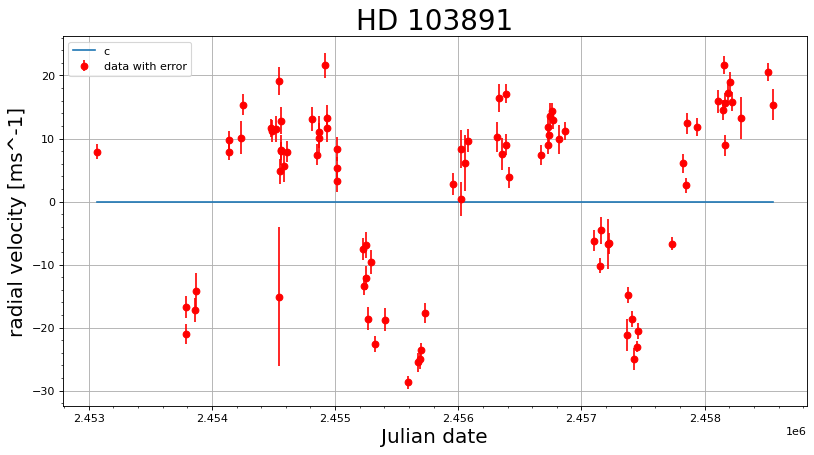

In [37]:
fig=plt.figure(figsize=(12, 6), dpi=80)

ax = fig.add_subplot(111)
ax.errorbar(t, vr,yerr=jitter,fmt='ro', label='data with error')
ax.set_title('HD 103891' ,  fontsize=25)
ax.minorticks_on()
ax.grid()

leng=len(t)
plt.plot(t,leng*[c] , label='c')
plt.xlabel('Julian date', fontsize='18')
plt.ylabel('radial velocity [ms^-1]', fontsize='18')
plt.legend()

plt.savefig('curvefitting29')
plt.show()

(18.027871545529585, 1838.6685034769748, 0.9530182989597629, -0.29258296364702735, 7.662421106316568)


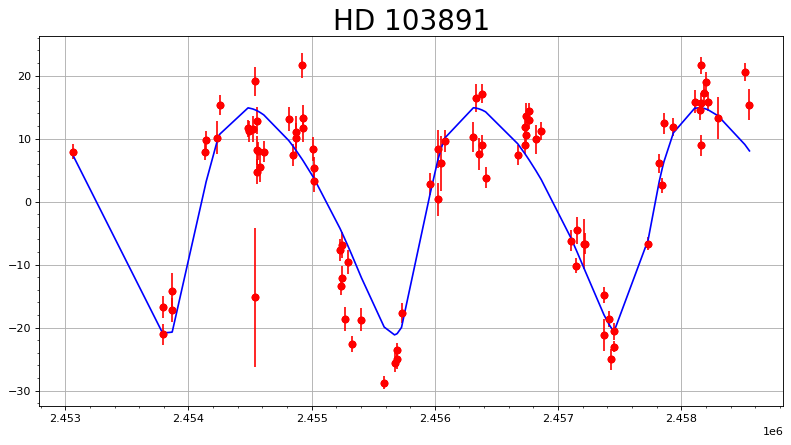

In [45]:
# Plot the time vs. velocity data and the radial velocity function

fig=plt.figure(figsize=(12, 6), dpi=80)

ax = fig.add_subplot(111)
ax.errorbar(t, vr,yerr=jitter,fmt='ro', label='data with error')
ax.set_title('HD 103891' ,  fontsize=25)
ax.minorticks_on()
ax.grid()

plt.plot(t, vr,'ro')
plt.plot(t,rv_function(t, K, P, w, e, n),'b')
print(tuple(popt))




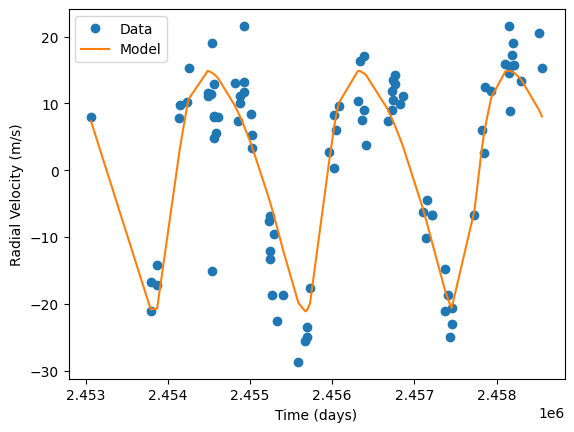

In [33]:
# Plot the time vs. velocity data and the radial velocity function
plt.plot(t, vr, 'o', label='Data')
plt.plot(t, rv_function(t, K, P, w, e, n), '-', label='Model')
plt.xlabel('Time (days)')
plt.ylabel('Radial Velocity (m/s)')
plt.legend()
plt.show()
